In [38]:
import pandas as pd
import seaborn as sns
import pandas as pd
from scipy import stats

import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.figure(figsize=(16,16))
sns.set(style="whitegrid", font_scale=1.5)

<Figure size 1152x1152 with 0 Axes>

Представьте, что вы работаете аналитиком в очень крупной компании по доставке пиццы над приложением для курьеров (да, обычно в таких компаниях есть приложение для курьеров и отдельно приложение для потребителей).

У вас есть несколько ресторанов в разных частях города и целый штат курьеров. Но есть одна проблема, к вечеру скорость доставки падает из-за того, что курьеры уходят домой после рабочего дня, а количество заказов лишь растет. Это приводит к тому, что в момент пересмены наша доставка очень сильно проседает в эффективности. 

Наши data scientist-ы придумали новый алгоритм, который позволяет курьерам запланировать свои последние заказы перед окончанием рабочего дня так, чтобы их маршрут доставки совпадал с маршрутом до дома. То есть, чтобы курьеры доставляли последние свои заказы за день как бы "по пути" домой. 

Вы вместе с командой решили раскатить A/B тест на две равные группы курьеров. Часть курьеров использует старый алгоритм без опции "по пути", другие видят в своем приложении эту опцию и могут ее выбрать. Ваша задача – проанализировать данные эксперимента и помочь бизнесу принять решение о раскатке новой фичи на всех курьеров.

Данные https://stepik.org/media/attachments/lesson/385916/experiment_lesson_4.csv   

Описание данных
- order_id - id заказа
- delivery_time - время доставки в минутах
- district - район доставки
- experiment_group - экспериментальная группа


In [2]:
df=pd.read_csv('https://stepik.org/media/attachments/lesson/385916/experiment_lesson_4.csv')

In [4]:
df

order_id  delivery_time  district experiment_group
0          3159           44.0  Purlieus          control
1         10426           51.0  Purlieus          control
2          9155           46.0  Purlieus          control
3         10699           34.0  Purlieus          control
4         10061           43.0  Purlieus          control
...         ...            ...       ...              ...
20191     14561           42.0    Suburb             test
20192     12015           32.0    Suburb             test
20193     20077           23.0  Purlieus             test
20194     14861           41.0   Central             test
20195     13501           41.0   Central             test

[20196 rows x 4 columns]

Сформулируем гипотезы:  
Нулевая гипотеза (H0): Разницы между средним временем доставки в тестовой и контрольной группе нет.  
Альтернативная гипотеза (H1): Разница между средним временем доставки в тестовой и контрольной группе есть.

1)Сопоставьте графики распределения и экспериментальные группы:

district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

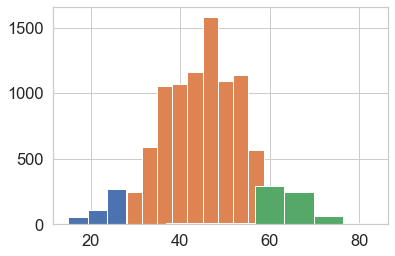

In [15]:
df.query('experiment_group == "control"').groupby('district').delivery_time.hist()


district
Central     AxesSubplot(0.125,0.125;0.775x0.755)
Purlieus    AxesSubplot(0.125,0.125;0.775x0.755)
Suburb      AxesSubplot(0.125,0.125;0.775x0.755)
Name: delivery_time, dtype: object

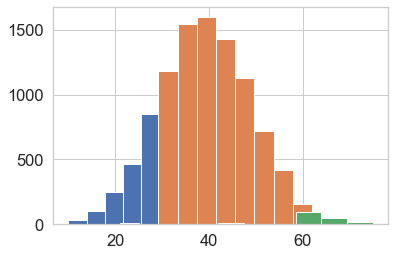

In [16]:
df.query('experiment_group == "test"').groupby('district').delivery_time.hist()

In [17]:
a=df.query('experiment_group == "control"').groupby('district').delivery_time

In [19]:
a.mean()

district
Central     26.239163
Purlieus    45.125384
Suburb      63.858255
Name: delivery_time, dtype: float64


Посчитайте количество наблюдений в тестовой и контрольной группе.
На сколько по модулю отличается количество наблюдений в тесте и контроле?

In [24]:
df.groupby('experiment_group',as_index=False).agg({'order_id':'count'}).T

0      1
experiment_group  control   test
order_id            10092  10104

In [25]:
10104-10092

12

Теперь давайте изучим наши распределения.
Проверим выполнение условий на нормальность и посчитаем стандартное отклонение в тесте и в контроле.
Обязательно сделайте семплирование перед применением критерия при проверке на нормальность (и для теста, и для контроля),
так как на больших выборках вы можете получать неверные результаты:

experiment[experiment['experiment_group'] == 'test']['delivery_time'].sample(1000, random_state=17)
Заполните пропуски ниже

In [34]:
# Берем не всю выборку, а 1000 значений из нее, если наше распределение нормальное, то и выборка будет нормальной
# random_state=17 позволяет сделать наши результаты более стабильными


In [47]:
control_group=df.query('experiment_group=="control"').delivery_time.sample(1000,random_state=17)



In [48]:
control_group

7144    42.0
6231    42.0
6902    41.0
7032    54.0
2009    44.0
        ... 
752     54.0
3754    63.0
5420    64.0
8119    49.0
4804    45.0
Name: delivery_time, Length: 1000, dtype: float64

In [49]:
shap_test_control_group=stats.shapiro(control_group)
print('pvalue = ',shap_test_control_group[1])
if shap_test_control_group[1]<0.05:
    print('Reject H0 that say us about normal distribution')
else:
    print('Normal distribution')

pvalue =  0.12411931157112122
Normal distribution


In [50]:
test_group=df.query('experiment_group=="test"').delivery_time.sample(1000,random_state=17)

In [51]:
shap_test_test_group=shap_test_control_group=stats.shapiro(test_group)
print('pvalue = ',shap_test_test_group[1])
if shap_test_test_group[1]<0.05:
    print('Reject H0 that say us about normal distribution')
else:
    print('Normal distribution')

pvalue =  0.14005419611930847
Normal distribution


In [55]:
std_test_group=round(df.query('experiment_group  == "test"').delivery_time.std(), 2)
print('std_test_group = ',std_test_group)

std_test_group =  9.88


In [56]:
std_control_group=round(df.query('experiment_group  == "control"').delivery_time.std(), 2)
print('std_control_group = ',std_control_group)

std_control_group =  9.99


In [ ]:
Пришло время сравнить средние в тесте и контроле.
Внимание: здесь уже не нужно пользоваться методом .sample() - он нам нужен был только для теста Шапиро-Уилка,
остальные тесты надо проводить на полных данных.

In [58]:
from scipy.stats import ttest_ind

In [60]:
ttest=ttest_ind(df.query('experiment_group == "control"').delivery_time,df.query('experiment_group == "test"').delivery_time)

In [62]:
print('pvalue = ',ttest[1])
if ttest[1]<0.05:
    print('Reject H0 ')
else:
    print('Not Reject H0')

pvalue =  0.0
Reject H0 


На сколько процентов изменилось среднее время доставки в тестовой группе (округлите до сотых)?

In [66]:
a=df.query('experiment_group == "control"').delivery_time.mean()

In [67]:
b=df.query('experiment_group == "test"').delivery_time.mean()

In [72]:
delta_percent=(b*100/a)-100

In [73]:
delta_percent

-13.354653121660817

# ВЫВОД: раскатываем новый алгоритм на всех, так как среднее время доставки статистически значимо изменилось. Среднее время доставки в тесте меньше, чем в контроле.